In [634]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras import metrics
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [180]:
# data loading

with gzip.open('../data/segment_with_noise/ll_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_gps_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gps_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.791014,0.203958


In [192]:
ll_seg_gps_noise[0][['y_norm_noise', 'x_norm_noise']].values[0]

array([0.79535004, 0.20348973])

In [443]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)
    # y_ll.append(list(df[['y_norm', 'x_norm']].itertuples(index=False, name=None)))

In [235]:
# 500 segment samples with length 77
len(x_ll), len(x_ll[0])

(500, 77)

In [236]:
len(x_ll[0]), len(x_ll[2])

(77, 77)

In [237]:
# 500 segment samples with length 3822
len(y_ll), len(y_ll[0])

(500, 3822)

In [238]:
np.array([0.1, 0.2, 0.3]).reshape((1,3,1))

array([[[0.1],
        [0.2],
        [0.3]]])

## model 1: LSTM based seq2seq model

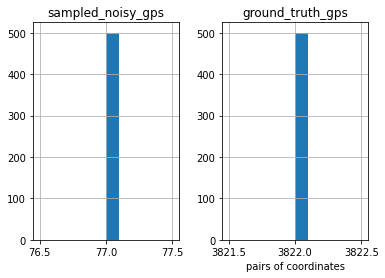

In [246]:
x_count = []
y_count = []

for x_seg in x_ll:
    x_count.append(len(x_seg))
for y_seg in y_ll:
    y_count.append(len(y_seg))

graph_df = pd.DataFrame() 

graph_df['sampled_noisy_gps'] = x_count
graph_df['ground_truth_gps'] = y_count

graph_df.hist(bins = 10)
plt.xlabel('pairs of coordinates')
plt.show()

In [240]:
# selecting max_y_len and max_x_len
max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

max_y_len, max_x_len

(3822, 77)

In [405]:
x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
y_temp = np.asarray([np.arange(max_y_len) for i in np.arange(len(y_ll))])

x_train_temp, x_val_temp = train_test_split(x_temp, test_size=0.1, random_state=0)
y_train_temp, y_val_temp = train_test_split(y_temp, test_size=0.1, random_state=0)

print(x_train_temp.shape, x_val_temp.shape)
x_train_temp

(450, 77) (50, 77)


array([[ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       ...,
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76],
       [ 0,  1,  2, ..., 74, 75, 76]])

In [297]:
x_train, x_val, y_train, y_val = train_test_split(
    np.asarray(x_ll),
    np.asarray(y_ll),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)
x_train.shape, x_val.shape

((450, 77, 2), (50, 77, 2))

In [212]:
# batch, seq_length, embedd_length
(Dense(64, )(x_train) + Embedding(max_x_len+1, 64, input_length=max_x_len+1)(x_train_temp)).shape

TensorShape([450, 77, 64])

In [640]:
embedding_dim = 128
latent_dim = 300

### network architecture

In [641]:
# assuming all input trajectories have shape 77x2
x_train_input = Input(shape=(77,2,))
# dense layer of spatial embedding
x_spatial_embedd = Dense(embedding_dim)

x_train_temp_input = Input(shape=(77,))
# temporal embedding
x_temporal_embedd = Embedding(max_x_len+1, embedding_dim, input_length=max_x_len+1, trainable=True) 

# combining two features to get spatio-temporal feature representation of input trajectory
x_h_st = Add()([x_spatial_embedd(x_train_input), x_temporal_embedd(x_train_temp_input)])
# x_h_st = spatial_embedd(x_train_input)

# Encoder
## Encoder LSTM 1
encoder_lstm1 = LSTM(
    latent_dim, return_sequences=True,
    return_state=True, dropout=0.2,
    recurrent_dropout=0.2
)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(x_h_st)

## Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

## Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)


# Decoder, assuming all target trajectories have shape 3822x2
y_train_input = Input(shape=(None,2,))
y_spatial_embedd = Dense(embedding_dim)

y_train_temp_input = Input(shape=(None,))
y_temporal_embedd = Embedding(max_y_len+1, embedding_dim, input_length=max_y_len+1, trainable=True)

y_h_st = Add()([y_spatial_embedd(y_train_input), y_temporal_embedd(y_train_temp_input)])
# y_h_st = spatial_embedd(y_train_input)

decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.2,
                    recurrent_dropout=0.1)

(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(y_h_st, initial_state=[state_h, state_c])

# Dense layer
# decoder_dense = TimeDistributed(Dense(2))#))

decoder_dense1 = Dense(latent_dim, activation = 'relu')
decoder_output1 = decoder_dense1(decoder_outputs)

decoder_dense3 = Dropout(0.3)
decoder_output2 = decoder_dense1(decoder_output1)

decoder_dense2 = TimeDistributed(Dense(2))#))
decoder_outputs = decoder_dense2(decoder_output2)

model = Model(inputs=[x_train_input, x_train_temp_input, y_train_input, y_train_temp_input], outputs=decoder_outputs)
## model = Model(inputs=[x_train_input, y_train_input], outputs=decoder_outputs)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[metrics.mean_absolute_percentage_error])

In [642]:
print(model.summary())

Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_157 (InputLayer)         [(None, 77, 2)]      0           []                               
                                                                                                  
 input_158 (InputLayer)         [(None, 77)]         0           []                               
                                                                                                  
 dense_107 (Dense)              (None, 77, 128)      384         ['input_157[0][0]']              
                                                                                                  
 embedding_65 (Embedding)       (None, 77, 128)      9984        ['input_158[0][0]']              
                                                                                           

In [555]:
x_train_temp.shape

(450, 77)

In [637]:
# runtime ~= 50min es at epoch = 28

# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll)
# y_train = np.asarray(y_ll)
y_train = np.asarray(y_gps_ll)

x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
# y_temp = np.asarray([np.arange(max_y_len) for i in np.arange(len(y_ll))])
y_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(y_gps_ll))])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(
    [x_train, x_temp, y_train[:, :-1], y_temp[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 2)[:, 1:],
    # [x_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 2)[:, 1:],
    # validation_data=[[x_val, x_val_temp, y_val, y_val_temp]],
    validation_split=0.2,
    batch_size=32, epochs=100, verbose='auto', callbacks=[es]
)

Epoch 1/100
13/13 [==============================] - 16s 743ms/step - loss: 0.1833 - mean_absolute_percentage_error: 23474.6660 - val_loss: 0.0890 - val_mean_absolute_percentage_error: 4983.0488
Epoch 2/100
13/13 [==============================] - 9s 682ms/step - loss: 0.0645 - mean_absolute_percentage_error: 5581.6875 - val_loss: 0.0388 - val_mean_absolute_percentage_error: 3412.3584
Epoch 3/100
13/13 [==============================] - 9s 695ms/step - loss: 0.0338 - mean_absolute_percentage_error: 2767.3018 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 2199.1692
Epoch 4/100
13/13 [==============================] - 9s 685ms/step - loss: 0.0261 - mean_absolute_percentage_error: 2067.6294 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 1239.0227
Epoch 5/100
13/13 [==============================] - 9s 687ms/step - loss: 0.0181 - mean_absolute_percentage_error: 1268.9935 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 1095.3771
Epoch 6/100
13/13 [==============

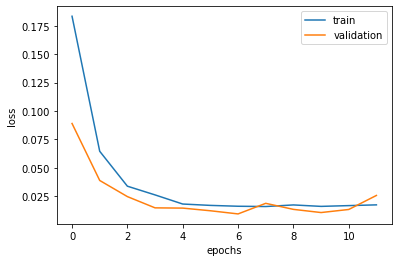

In [638]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

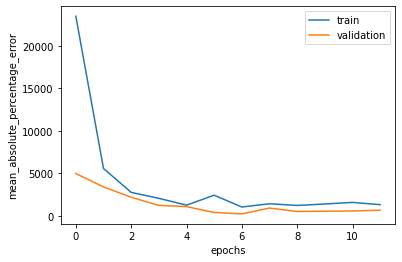

In [639]:
plt.plot(history.history['mean_absolute_percentage_error'], label='train')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('mean_absolute_percentage_error')
plt.legend()
plt.show()

In [615]:
model.save('../models/v1')
model = keras.models.load_model('../models/v1')

INFO:tensorflow:Assets written to: ../models/v1/assets


INFO:tensorflow:Assets written to: ../models/v1/assets


## inference models:
- input encoder
- feature decoder

In [616]:
# encoder
encoder_model = Model(
    inputs=[x_train_input, x_train_temp_input],
    outputs=[encoder_outputs, state_h, state_c])

# decoder
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_x_len, latent_dim))

y_h_st2 = Add()([y_spatial_embedd(y_train_input), y_temporal_embedd(y_train_temp_input)])
## y_h_st2 = spatial_embedd(y_train_input)

(decoder_outputs2, state_h2, state_c2) = decoder_lstm(y_h_st2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# output list of 2d coordinates as prediction directly
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    inputs = [y_train_input, y_train_temp_input] + \
        [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    ## inputs = [y_train_input] + \
    ##    [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],

    outputs = [decoder_outputs2] + [state_h2, state_c2])

In [617]:
def decode_sequence(input_traj, pred_traj_length=77):

    # encode the input as state vectors
    input_traj_temp = np.arange(input_traj.shape[1]).reshape(1, input_traj.shape[1])
    ## (e_out, e_h, e_c) = encoder_model.predict(input_traj)
    (e_out, e_h, e_c) = encoder_model.predict([input_traj, input_traj_temp])
    # ***use the first coordinate pair of input traj to start***
    target_traj = input_traj[0][0].reshape(1, 2)
    target_traj_temp = np.arange(1).reshape(1, 1)
    pred_traj = np.zeros(shape=(pred_traj_length, 2))

    for i in np.arange(pred_traj_length):
        (output_traj, h, c) = decoder_model.predict(
            [target_traj, target_traj_temp] + [e_out, e_h, e_c])
        ## (output_traj, h, c) = decoder_model.predict(
        ##    [target_traj] + [e_out, e_h, e_c])

        # add to results and update next target_traj of length 1
        pred_traj[i] = output_traj[0][-1]
        target_traj = output_traj

        # update internal states for next prediction
        (e_h, e_c) = (h, c)
        
    return pred_traj

In [621]:
predicted = decode_sequence(x_train[1].reshape(1, max_x_len, 2))
predicted.shape, x_train[1].shape

((77, 2), (77, 2))

In [625]:
predicted[0], x_train[1][0]

(array([0.85418522, 0.20302267]), array([0.81042913, 0.23955122]))

In [622]:
np.mean(tf.keras.metrics.mape(
    y_train[1], predicted
))

70.69801046746865

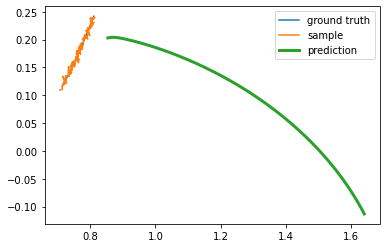

In [632]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.plot(y_train[1][:, 0], y_train[1][:, 1], label='ground truth')
plt.plot(x_train[1][:, 0], x_train[1][:, 1], label='sample')
plt.plot(predicted[:, 0], predicted[:, 1], label='prediction', linewidth=3)

plt.legend()
plt.show()